# Read and process data

In [41]:
import numpy as np
import pandas as pd
from rulevetting.projects.tbi_pecarn.dataset import Dataset
pd.set_option("display.max_colwidth",1000)

## Read data

In [2]:
df_train, df_tune, df_test = Dataset().get_data(load_csvs=False)

kwargs {'clean_data': {}, 'preprocess_data': {'step1_injMech': False, 'step5_missSubGCS': True, 'step5_fake15GCS': True, 'step5_fake14GCS': True, 'step8_missingOSI': True, 'step9_HEMA': 3, 'step10_cautiousUncl': True, 'step14_vomitDtls': False, 'step15_HA': 2, 'step15_HAStart': False, 'step16_Seiz': 2, 'step16_SeizOccur': False, 'step17_cautiousUncl': True, 'step19_Drugs': False, 'step20_ActNormal': True}, 'extract_features': {'HEMA_umbrella': False, 'SFxPalp_umbrella': False, 'SFxBas_umbrella': False, 'AMS_umbrella': False, 'Clav_umbrella': False, 'NeuroD_umbrella': False, 'Vomit_umbrella': False, 'HA_umbrella': False, 'Seiz_umbrella': False, 'LOC_umbrella': False, 'remove_constVal': True}}


## 60% 20% 20% splitting

In [3]:
print(df_train.shape)
print(df_tune.shape)
print(df_test.shape)

(19947, 138)
(6649, 138)
(6649, 138)


In [4]:
df_train.keys().tolist()

['LOCSeparate',
 'Seiz',
 'ActNorm',
 'Vomit',
 'GCSEye',
 'GCSVerbal',
 'GCSMotor',
 'GCSTotal',
 'AMS',
 'SFxPalp',
 'FontBulg',
 'SFxBas',
 'Hema',
 'Clav',
 'NeuroD',
 'OSI',
 'AgeinYears',
 'Gender',
 'Race',
 'outcome',
 'High_impact_InjSev_1',
 'High_impact_InjSev_2',
 'High_impact_InjSev_3',
 'Amnesia_verb_0',
 'Amnesia_verb_1',
 'Amnesia_verb_91',
 'LocLen_1',
 'LocLen_2',
 'LocLen_3',
 'LocLen_4',
 'LocLen_92',
 'SeizLen_1',
 'SeizLen_2',
 'SeizLen_3',
 'SeizLen_4',
 'SeizLen_92',
 'HA_verb_0',
 'HA_verb_1',
 'HA_verb_91',
 'HASeverity_1',
 'HASeverity_2',
 'HASeverity_3',
 'HASeverity_92',
 'AMSAgitated_0',
 'AMSAgitated_1',
 'AMSAgitated_92',
 'AMSSleep_0',
 'AMSSleep_1',
 'AMSSleep_92',
 'AMSSlow_0',
 'AMSSlow_1',
 'AMSSlow_92',
 'AMSRepeat_0',
 'AMSRepeat_1',
 'AMSRepeat_92',
 'AMSOth_0',
 'AMSOth_1',
 'AMSOth_92',
 'SFxPalpDepress_0',
 'SFxPalpDepress_1',
 'SFxPalpDepress_92',
 'SFxBasHem_0',
 'SFxBasHem_1',
 'SFxBasHem_92',
 'SFxBasOto_0',
 'SFxBasOto_1',
 'SFxBasOto_92

In [5]:
df_train.AgeinYears

PatNum
1788     8
11823    3
41601    5
22608    3
2980     3
        ..
9669     1
31876    7
11121    1
13306    1
30841    2
Name: AgeinYears, Length: 19947, dtype: int64

In [6]:
np.unique(df_train.GCSTotal)

array([14, 15])

In [7]:
df_train.outcome

PatNum
1788     0
11823    0
41601    0
22608    0
2980     0
        ..
9669     0
31876    0
11121    0
13306    0
30841    0
Name: outcome, Length: 19947, dtype: int64

In [8]:
aa=df_train[df_train.isna().any(axis=1)]
(aa.sum(axis=0,skipna=False))[aa.sum(axis=0,skipna=False).isna()]

Gender   NaN
Race     NaN
dtype: float64

## Age group - focus on age >= 2 & metakeys removed

###### should we split data by agegroup?

In [9]:
df_train_old = df_train[df_train.AgeinYears >= 2]
df_train_old = df_train_old.drop(columns=['AgeinYears','Race','Gender'])
df_tune_old = df_tune[df_tune.AgeinYears >= 2]
df_tune_old = df_tune_old.drop(columns=['AgeinYears','Race','Gender'])

In [10]:
X_train_old = df_train_old.drop(columns="outcome")
y_train_old = df_train_old["outcome"].values
X_tune_old = df_tune_old.drop(columns="outcome")
y_tune_old = df_tune_old["outcome"].values


# Fit models

In [11]:
import os
import pickle as pkl
from os.path import join as oj

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree

import numpy as np
import pandas as pd

import imodels
from rulevetting.api import validation


MODELS_DIR = './models'
os.makedirs(MODELS_DIR, exist_ok=True)

outcome_def = 'outcome'  # output

In [12]:
def predict_and_save(model, model_name, X_train, X_tune, y_train, y_tune):
    '''Plots cv and returns cv, saves all stats
    '''
    results = {'model': model}
    for x, y, suffix in zip([X_train, X_tune],
                            [y_train, y_tune],
                            ['_train', '_tune']):
        stats, threshes = validation.all_stats_curve(y, model.predict_proba(x)[:, 1],
                                                     plot=suffix == '_tune')
        for stat in stats.keys():
            results[stat + suffix] = stats[stat]
        results['threshes' + suffix] = threshes
    pkl.dump(results, open(oj(MODELS_DIR, model_name + '.pkl'), 'wb'))
    return stats, threshes

In [13]:
feature_names=list(X_train_old).copy()

## RuleFit

100%|███████████████████████████████████████| 131/131 [00:00<00:00, 1436.06it/s]


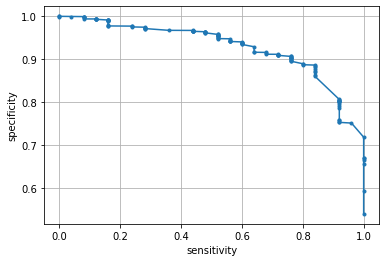

In [47]:
# fit a rulefit model
np.random.seed(215)
rulefit = imodels.RuleFitRegressor(max_rules=5)
rulefit.fit(X_train_old, y_train_old, feature_names=feature_names)

stats, threshes = predict_and_save(rulefit, 'rulefit', X_train_old, X_tune_old, y_train_old, y_tune_old)

In [48]:
rules = rulefit.get_rules() 
rules = rules[rules['type']!='linear']
rules = rules[rules['coef'] != 0] 
rules = rules.sort_values('importance', ascending=False) 
rules

,rule,type,coef,support,importance
137,NeuroDSensory_1 <= 0.5 and Vomit <= 0.5 and SFxBasHem_1 <= 0.5,rule,-0.008028,0.880480,0.002604
136,AMSSleep_1 <= 0.5 and SFxBasHem_1 <= 0.5 and NeuroDMotor_1 <= 0.5,rule,-0.005860,0.936947,0.001424
134,LocLen_4 <= 0.5 and AMSSlow_1 <= 0.5 and HemaSize_3 <= 0.5,rule,-0.004606,0.902642,0.001366
138,SFxBasHem_1 <= 0.5 and ClavPar_1 <= 0.5,rule,-0.004423,0.920686,0.001195
135,High_impact_InjSev_3 <= 0.5 and GCSEye > 3.5,rule,-0.001088,0.889125,0.000342


###### Rulefit is a linear model (LASSO?) with new features derived by other methods(decision trees?). I'm also not sure whether the model we use here is regression or classification.  


###### Does umbrella structure matters?

###### In this result, the top 4 rules seem to be most important (importance > 0.001). And per rule, is there any relation of these variables in domain knowledge?

###### Results seem to be not reproducible even I set the seed. Stability check?

100%|███████████████████████████████████████| 166/166 [00:00<00:00, 1387.24it/s]


,rule,type,coef,support,importance
138,AMSSlow_1 <= 0.5 and GCSMotor > 5.5 and SFxBasPer_0 <= 0.5,rule,-0.020905,0.968645,0.003643
139,NeuroDSensory_1 <= 0.5 and Vomit <= 0.5 and SFxBasHem_1 <= 0.5,rule,-0.008171,0.880480,0.002651
136,AMSSleep_1 <= 0.5 and SFxBasHem_1 <= 0.5,rule,-0.005290,0.939623,0.001260
140,AMSSlow_0 <= 0.5 and SFxBasHem_1 <= 0.5,rule,-0.002429,0.924803,0.000641
137,SeizLen_2 <= 0.5 and GCSVerbal > 4.5 and HemaSize_3 <= 0.5,rule,-0.002139,0.918902,0.000584
135,High_impact_InjSev_3 <= 0.5 and GCSEye > 3.5,rule,-0.001803,0.889125,0.000566
134,SFxBasHem_1 <= 0.5 and HemaLoc_3 <= 0.5 and ClavTem_1 <= 0.5,rule,-0.001447,0.889194,0.000454


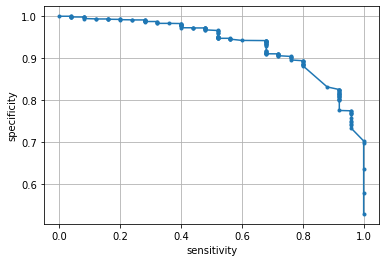

In [49]:
# fit a rulefit model
np.random.seed(215)
rulefit = imodels.RuleFitRegressor(max_rules=8)
rulefit.fit(X_train_old, y_train_old, feature_names=feature_names)

stats, threshes = predict_and_save(rulefit, 'rulefit', X_train_old, X_tune_old, y_train_old, y_tune_old)
rules = rulefit.get_rules() 
rules = rules[rules['type']!='linear']
rules = rules[rules['coef'] != 0] 
rules = rules.sort_values('importance', ascending=False) 
rules

## greedy (CART) rule list

/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 1169.06it/s]


mean 0.006 (14575 pts)
if SFxBasHem_1 >= 1.0 then 0.267 (45 pts)
mean 0.005 (14530 pts)
if feat 51 >= 1.0 then 0.03 (1227 pts)
mean 0.003 (13303 pts)
if feat 55 >= 1.0 then 0.182 (11 pts)
mean 0.003 (13292 pts)
if feat 107 >= 1.0 then 0.038 (184 pts)
mean 0.002 (13108 pts)
if feat 20 >= 1.0 then 0.012 (1060 pts)
mean 0.002 (12048 pts)
if feat 117 >= 1.0 then 0.111 (9 pts)
mean 0.001 (12039 pts)
if feat 126 >= 1.0 then 0.021 (96 pts)
mean 0.001 (11943 pts)
if feat 3 >= 1.0 then 0.006 (1100 pts)
mean 0.001 (10843 pts)
if feat 37 >= 1.0 then 0.014 (139 pts)
mean 0.001 (10704 pts)
if feat 93 >= 1.0 then 0.003 (912 pts)
mean 0.0 (9792 pts)
if feat 24 >= 1.0 then 0.008 (133 pts)
mean 0.0 (9659 pts)
if feat 81 >= 1.0 then 0.001 (3369 pts)
mean 0 (6290 pts)



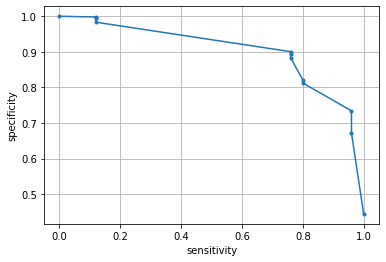

In [31]:
class_weight = {0: 1, 1: 100}
grl = imodels.GreedyRuleListClassifier(max_depth=12, class_weight=class_weight, criterion='neg_corr')
grl.fit(X_train_old, y_train_old, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(grl,'grl', X_train_old, X_tune_old, y_train_old, y_tune_old)
# grl.print_list()
print(grl)

In [89]:
X_train_old_1 = X_train_old[X_train_old['SFxBasHem_1'] < 1]
y_train_old_1 = y_train_old[X_train_old['SFxBasHem_1'] < 1]

In [90]:
y_train_old_1.shape

(14530,)

In [91]:
list(X_train_old)[51]

'AMSOth_0'

In [92]:
X_train_old_2 = X_train_old_1[X_train_old_1['AMSOth_0'] < 1]
y_train_old_2 = y_train_old_1[X_train_old_1['AMSOth_0'] < 1]
y_train_old_2.shape

(13303,)

In [104]:
lst = [list(X_train_old)[i] for i in [51, 55, 107, 20, 117, 126, 3, 37, 93, 24, 81]]
lst.insert(0, 'SFxBasHem_1')
lst

['SFxBasHem_1',
 'AMSOth_0',
 'SFxPalpDepress_1',
 'NeuroDReflex_0',
 'Amnesia_verb_1',
 'OSICut_1',
 'OSIAbdomen_1',
 'Vomit',
 'HASeverity_3',
 'ClavPar_1',
 'LocLen_3',
 'ClavFace_1']

In [112]:
print(grl)
print('\n \n \n')
print(lst)

mean 0.006 (14575 pts)
if SFxBasHem_1 >= 1.0 then 0.267 (45 pts)
mean 0.005 (14530 pts)
if feat 51 >= 1.0 then 0.03 (1227 pts)
mean 0.003 (13303 pts)
if feat 55 >= 1.0 then 0.182 (11 pts)
mean 0.003 (13292 pts)
if feat 107 >= 1.0 then 0.038 (184 pts)
mean 0.002 (13108 pts)
if feat 20 >= 1.0 then 0.012 (1060 pts)
mean 0.002 (12048 pts)
if feat 117 >= 1.0 then 0.111 (9 pts)
mean 0.001 (12039 pts)
if feat 126 >= 1.0 then 0.021 (96 pts)
mean 0.001 (11943 pts)
if feat 3 >= 1.0 then 0.006 (1100 pts)
mean 0.001 (10843 pts)
if feat 37 >= 1.0 then 0.014 (139 pts)
mean 0.001 (10704 pts)
if feat 93 >= 1.0 then 0.003 (912 pts)
mean 0.0 (9792 pts)
if feat 24 >= 1.0 then 0.008 (133 pts)
mean 0.0 (9659 pts)
if feat 81 >= 1.0 then 0.001 (3369 pts)
mean 0 (6290 pts)


 
 

['SFxBasHem_1', 'AMSOth_0', 'SFxPalpDepress_1', 'NeuroDReflex_0', 'Amnesia_verb_1', 'OSICut_1', 'OSIAbdomen_1', 'Vomit', 'HASeverity_3', 'ClavPar_1', 'LocLen_3', 'ClavFace_1']


###### Cart is interpretable. The interpretation way is quite similar to the article. But note this is a greedy method. And we can also tune the class weight for stability check.

###### The rule is based on top12. Actually top9 or top8 is enough. But notice there are two SFx variables, two OSI variables. 

###### AMSOth and NeuroDReflex are (conditionaly) negative correlated to outcome?

## Decision tree

100%|█████████████████████████████████████████| 13/13 [00:00<00:00, 1065.21it/s]


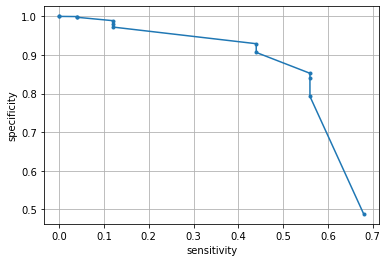

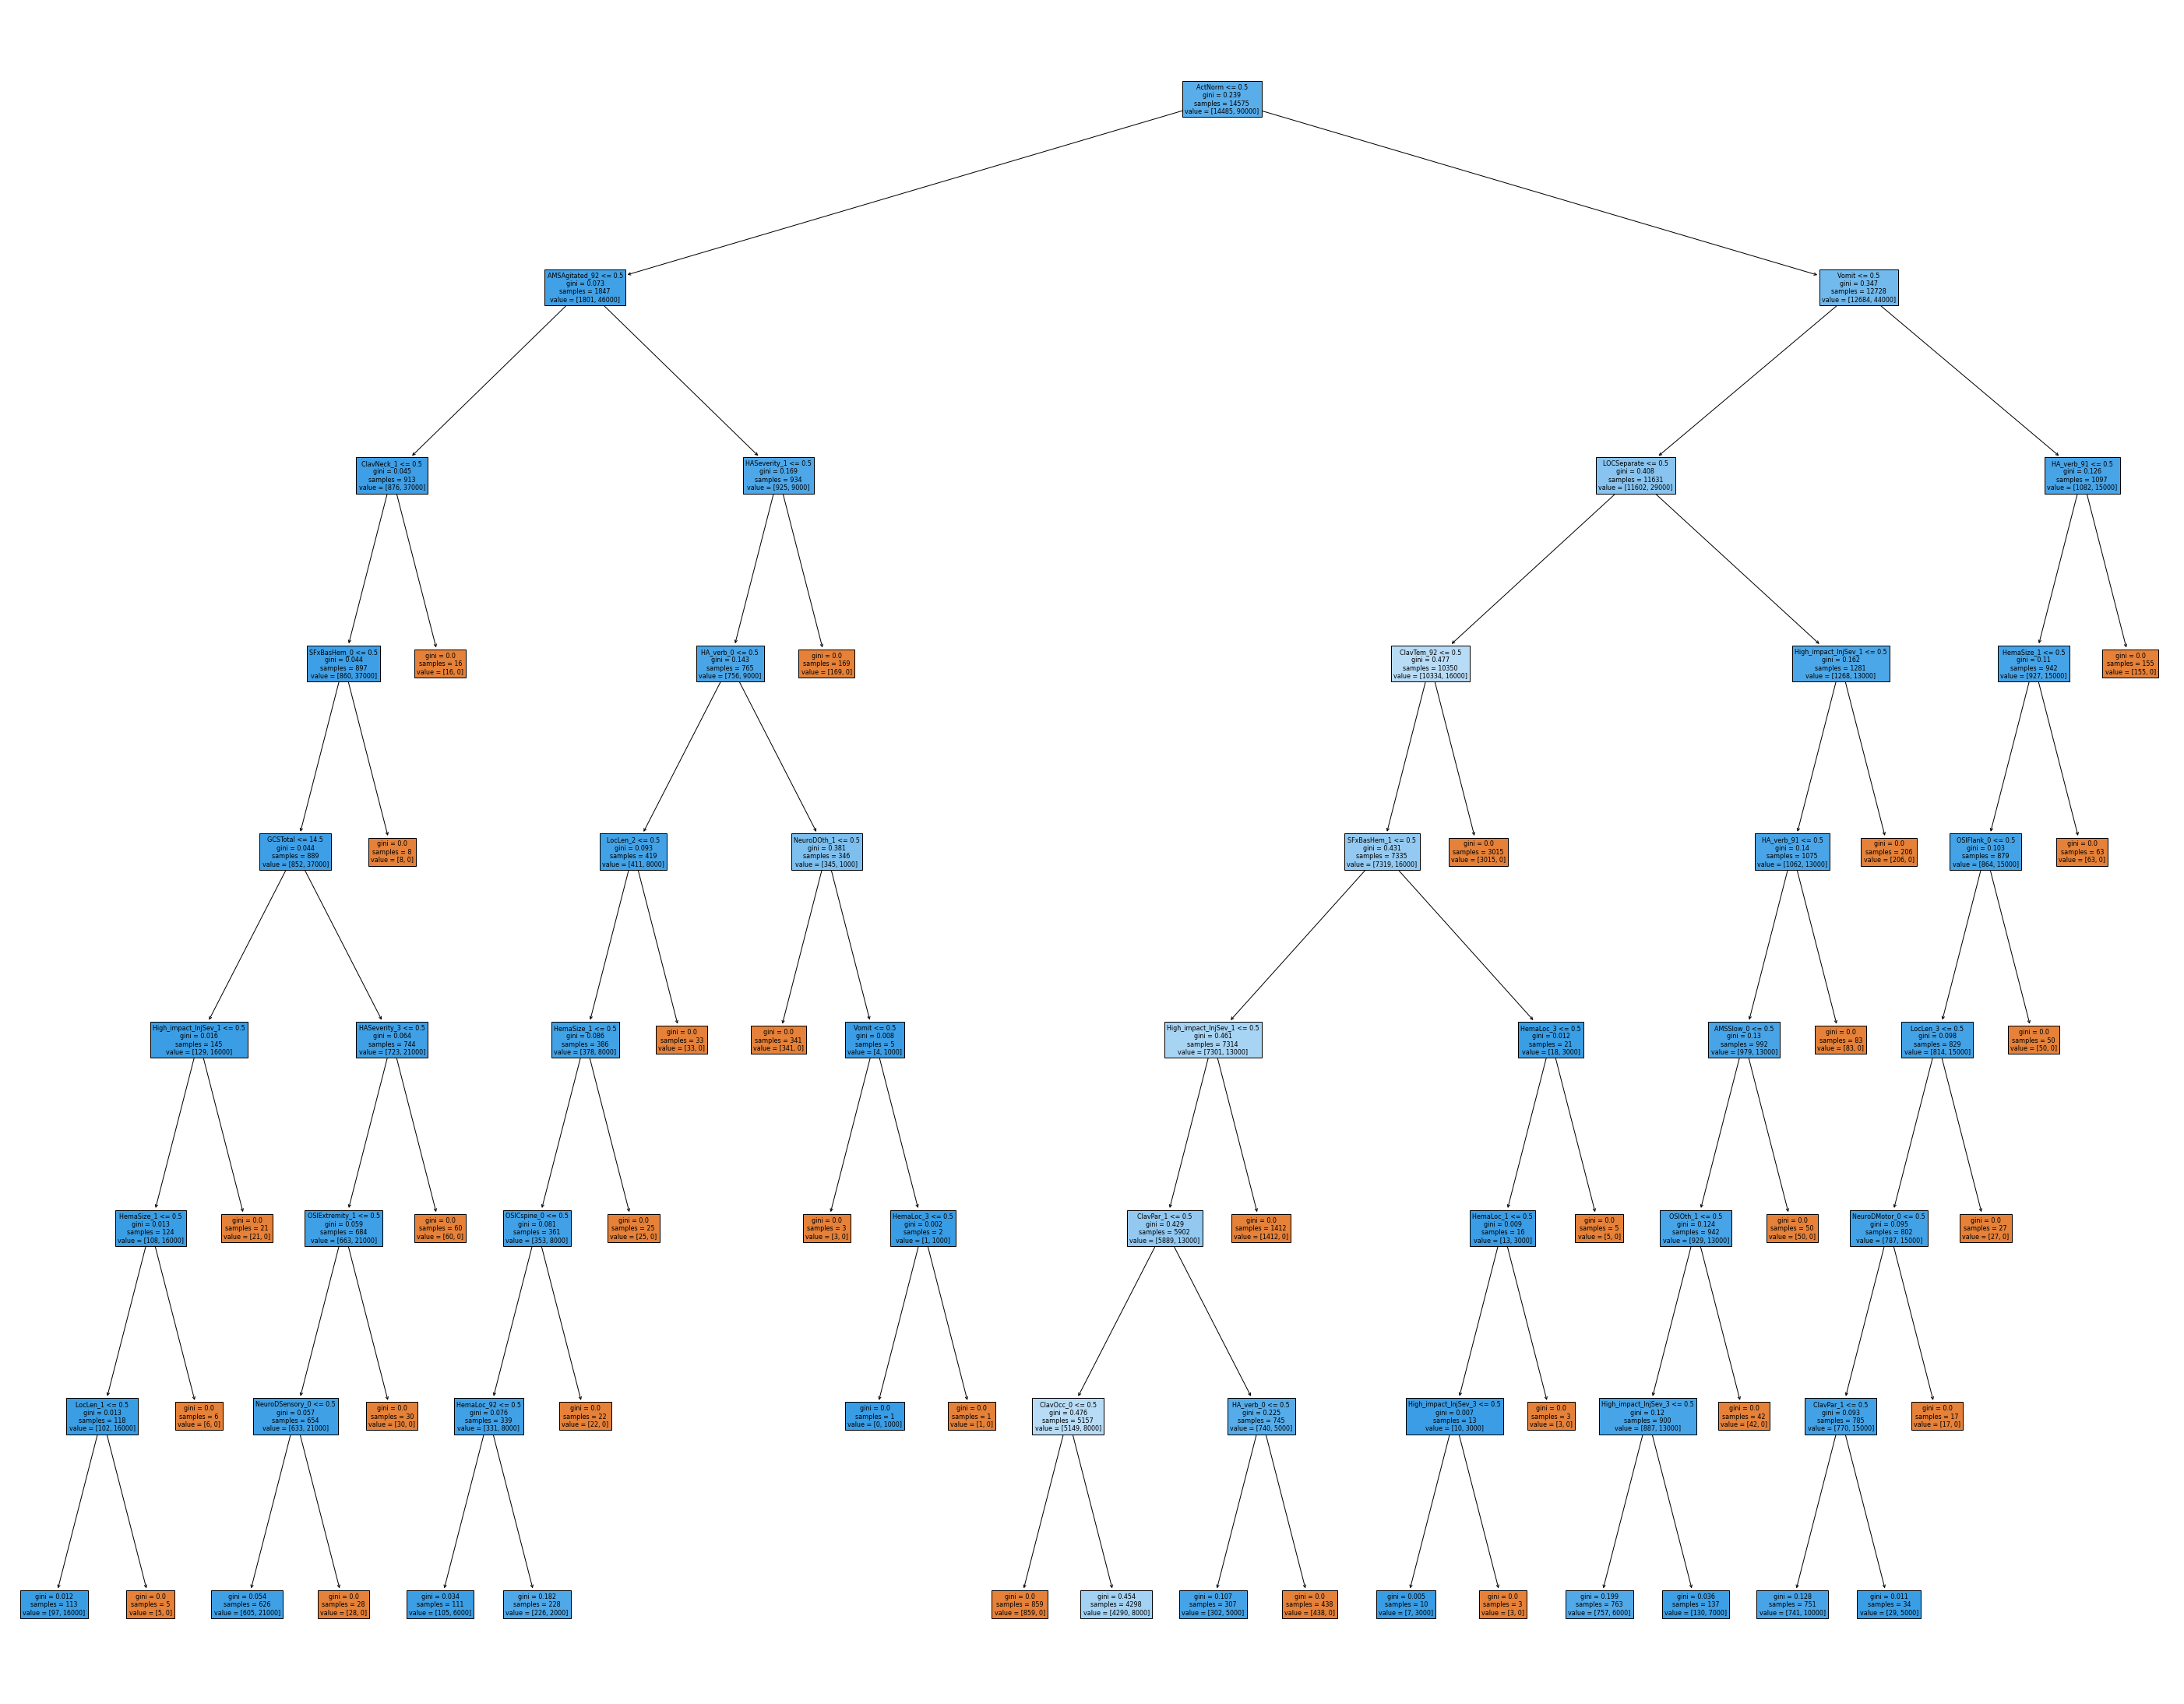

In [115]:
np.random.seed(125)
# fit decition tree
dt = DecisionTreeClassifier(max_depth=8, class_weight={0: 1, 1: 1e3})
dt.fit(X_train_old, y_train_old)
stats, threshes = predict_and_save(dt,'decision_tree', X_train_old, X_tune_old, y_train_old, y_tune_old)
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

###### Decision tree. We can tune class weight /max depth to check stability.

###### The most important one is ActNorm. Is it reasonable? It is not appeared in CART. Then other nodes (variables) near the root is AMSAgitated92 (Is it interpretable?), Vomit, HA, LOC, ClavNeck, SFxBasHem.

###### No nuroD variables very near root. Maybe refit the model.

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 721.61it/s]


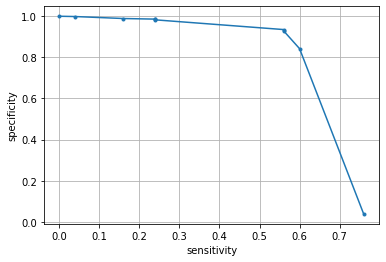

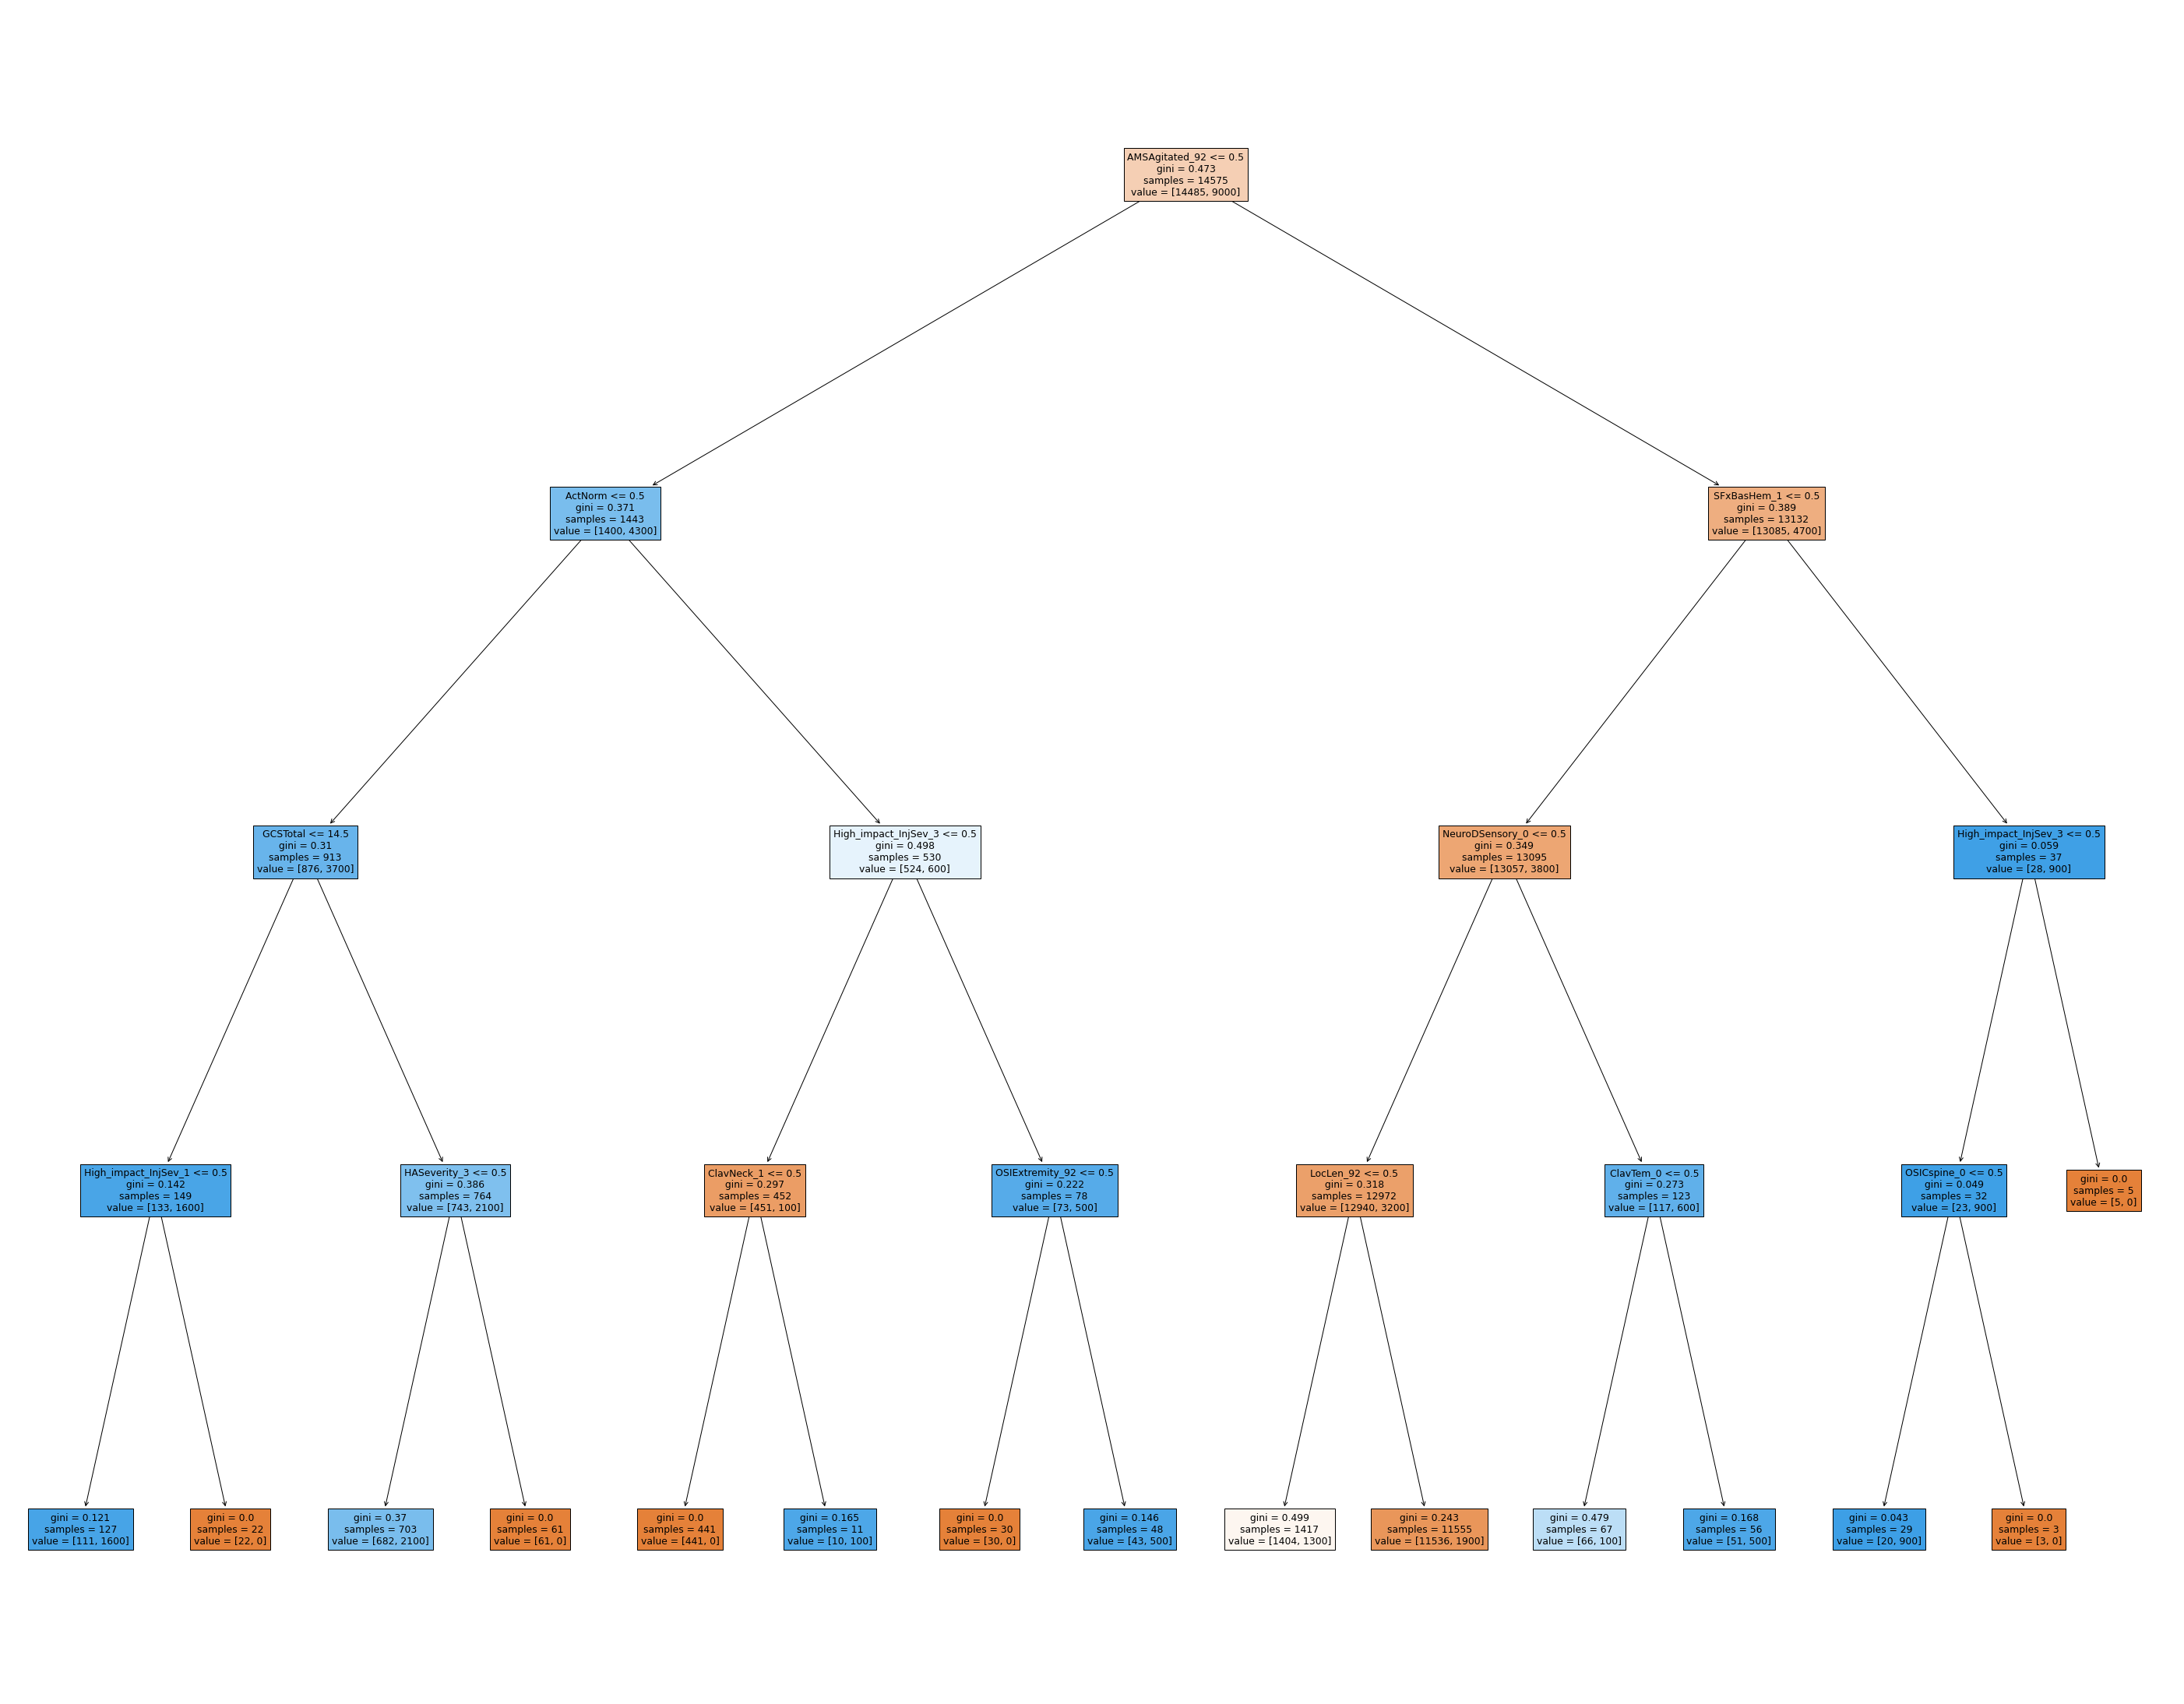

In [51]:
np.random.seed(125)
# fit decition tree
dt = DecisionTreeClassifier(max_depth=4, class_weight={0: 1, 1: 1e2})
dt.fit(X_train_old, y_train_old)
stats, threshes = predict_and_save(dt,'decision_tree', X_train_old, X_tune_old, y_train_old, y_tune_old)
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()

###### AMSAmitigated92 (?), Actnorm(?), SFxBasHem, GCSTotal, NeuroD, High_impact_inj. 

###### No Vomit now. And why AMS appears only in AMSAmitigated92?

## Interpretation

#### Overall, SFxBasHem appears at all models. AMS is quite inportant in Amitigate92(why?). Other variables are related to outcome: NeuroDeficit, GCSTotal, High_impact_inj. 

#### may be related to outcomes: Amnesia_verb, OSI.

## Age group young. -No interpretations now

In [15]:
df_train_young = df_train[df_train.AgeinYears < 2]
df_train_young = df_train_young.drop(columns=['AgeinYears','Race','Gender'])
df_tune_young = df_tune[df_tune.AgeinYears < 2]
df_tune_young = df_tune_young.drop(columns=['AgeinYears','Race','Gender'])

In [16]:
X_train_young = df_train_young.drop(columns="outcome")
y_train_young = df_train_young["outcome"].values
X_tune_young = df_tune_young.drop(columns="outcome")
y_tune_young = df_tune_young["outcome"].values


## RuleFit

100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 1463.98it/s]


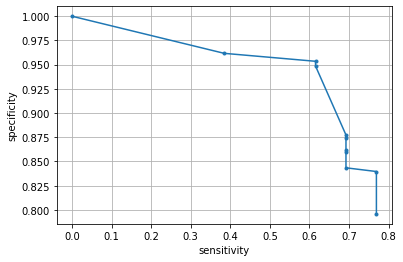

In [21]:
# fit a rulefit model
np.random.seed(215)
rulefit = imodels.RuleFitRegressor(max_rules=4)
rulefit.fit(X_train_young, y_train_young, feature_names=feature_names)

stats, threshes = predict_and_save(rulefit, 'rulefit', X_train_young, X_tune_young, y_train_young, y_tune_young)

In [22]:
rules = rulefit.get_rules() 
rules = rules[rules['type']!='linear']
rules = rules[rules['coef'] != 0] 
rules = rules.sort_values('importance', ascending=False) 
rules

,rule,type,coef,support,importance
134,SFxPalpDepress_92 > 0.5 and SFxBasHem_1 <= 0.5...,rule,-0.014876,0.870067,0.005002
137,SFxBas <= 0.5 and GCSVerbal > 4.5 and SFxPalpD...,rule,-0.012888,0.932800,0.003227
136,SeizLen_4 <= 0.5 and SeizLen_92 > 0.5 and AMSA...,rule,-0.003389,0.830045,0.001273
135,LocLen_2 <= 0.5 and AMSOth_92 > 0.5 and SFxPal...,rule,-0.001206,0.879002,0.000393


## greedy (CART) rule list

/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
100%|█████████████████████████████████████████| 11/11 [00:00<00:00, 1558.96it/s]

mean 0.008 (5372 pts)
if SFxPalpDepress_0 >= 1.0 then 0.308 (13 pts)
mean 0.008 (5359 pts)
if feat 55 >= 1.0 then 0.286 (14 pts)
mean 0.007 (5345 pts)
if feat 30 >= 1.0 then 1.0 (1 pts)
mean 0.007 (5344 pts)
if feat 61 >= 1.0 then 0.5 (2 pts)
mean 0.007 (5342 pts)
if feat 42 >= 1.0 then 0.044 (296 pts)
mean 0.004 (5046 pts)
if feat 40 >= 1.0 then 0.136 (22 pts)
mean 0.004 (5024 pts)
if feat 74 >= 1.0 then 0.024 (455 pts)
mean 0.002 (4569 pts)
if feat 57 >= 1.0 then 0.111 (9 pts)
mean 0.002 (4560 pts)
if feat 27 >= 1.0 then 0.056 (18 pts)
mean 0.001 (4542 pts)
if feat 24 >= 1.0 then 0.026 (38 pts)
mean 0.001 (4504 pts)
if feat 96 >= 1.0 then 0.019 (52 pts)
mean 0.001 (4452 pts)
if feat 18 >= 1.0 then 0.003 (907 pts)



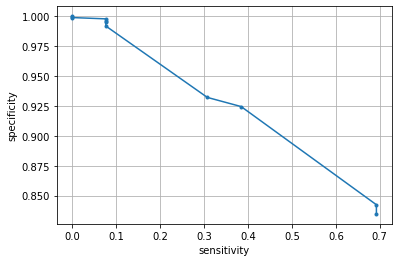

In [19]:
class_weight = {0: 1, 1: 100}
grl = imodels.GreedyRuleListClassifier(max_depth=12, class_weight=class_weight, criterion='neg_corr')
grl.fit(X_train_young, y_train_young, feature_names=feature_names, verbose=False)
stats, threshes = predict_and_save(grl,'grl', X_train_young, X_tune_young, y_train_young, y_tune_young)
# grl.print_list()
print(grl)

## Decision tree

100%|███████████████████████████████████████████| 8/8 [00:00<00:00, 1289.51it/s]


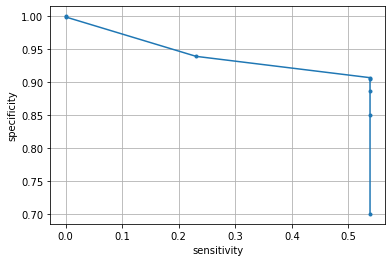

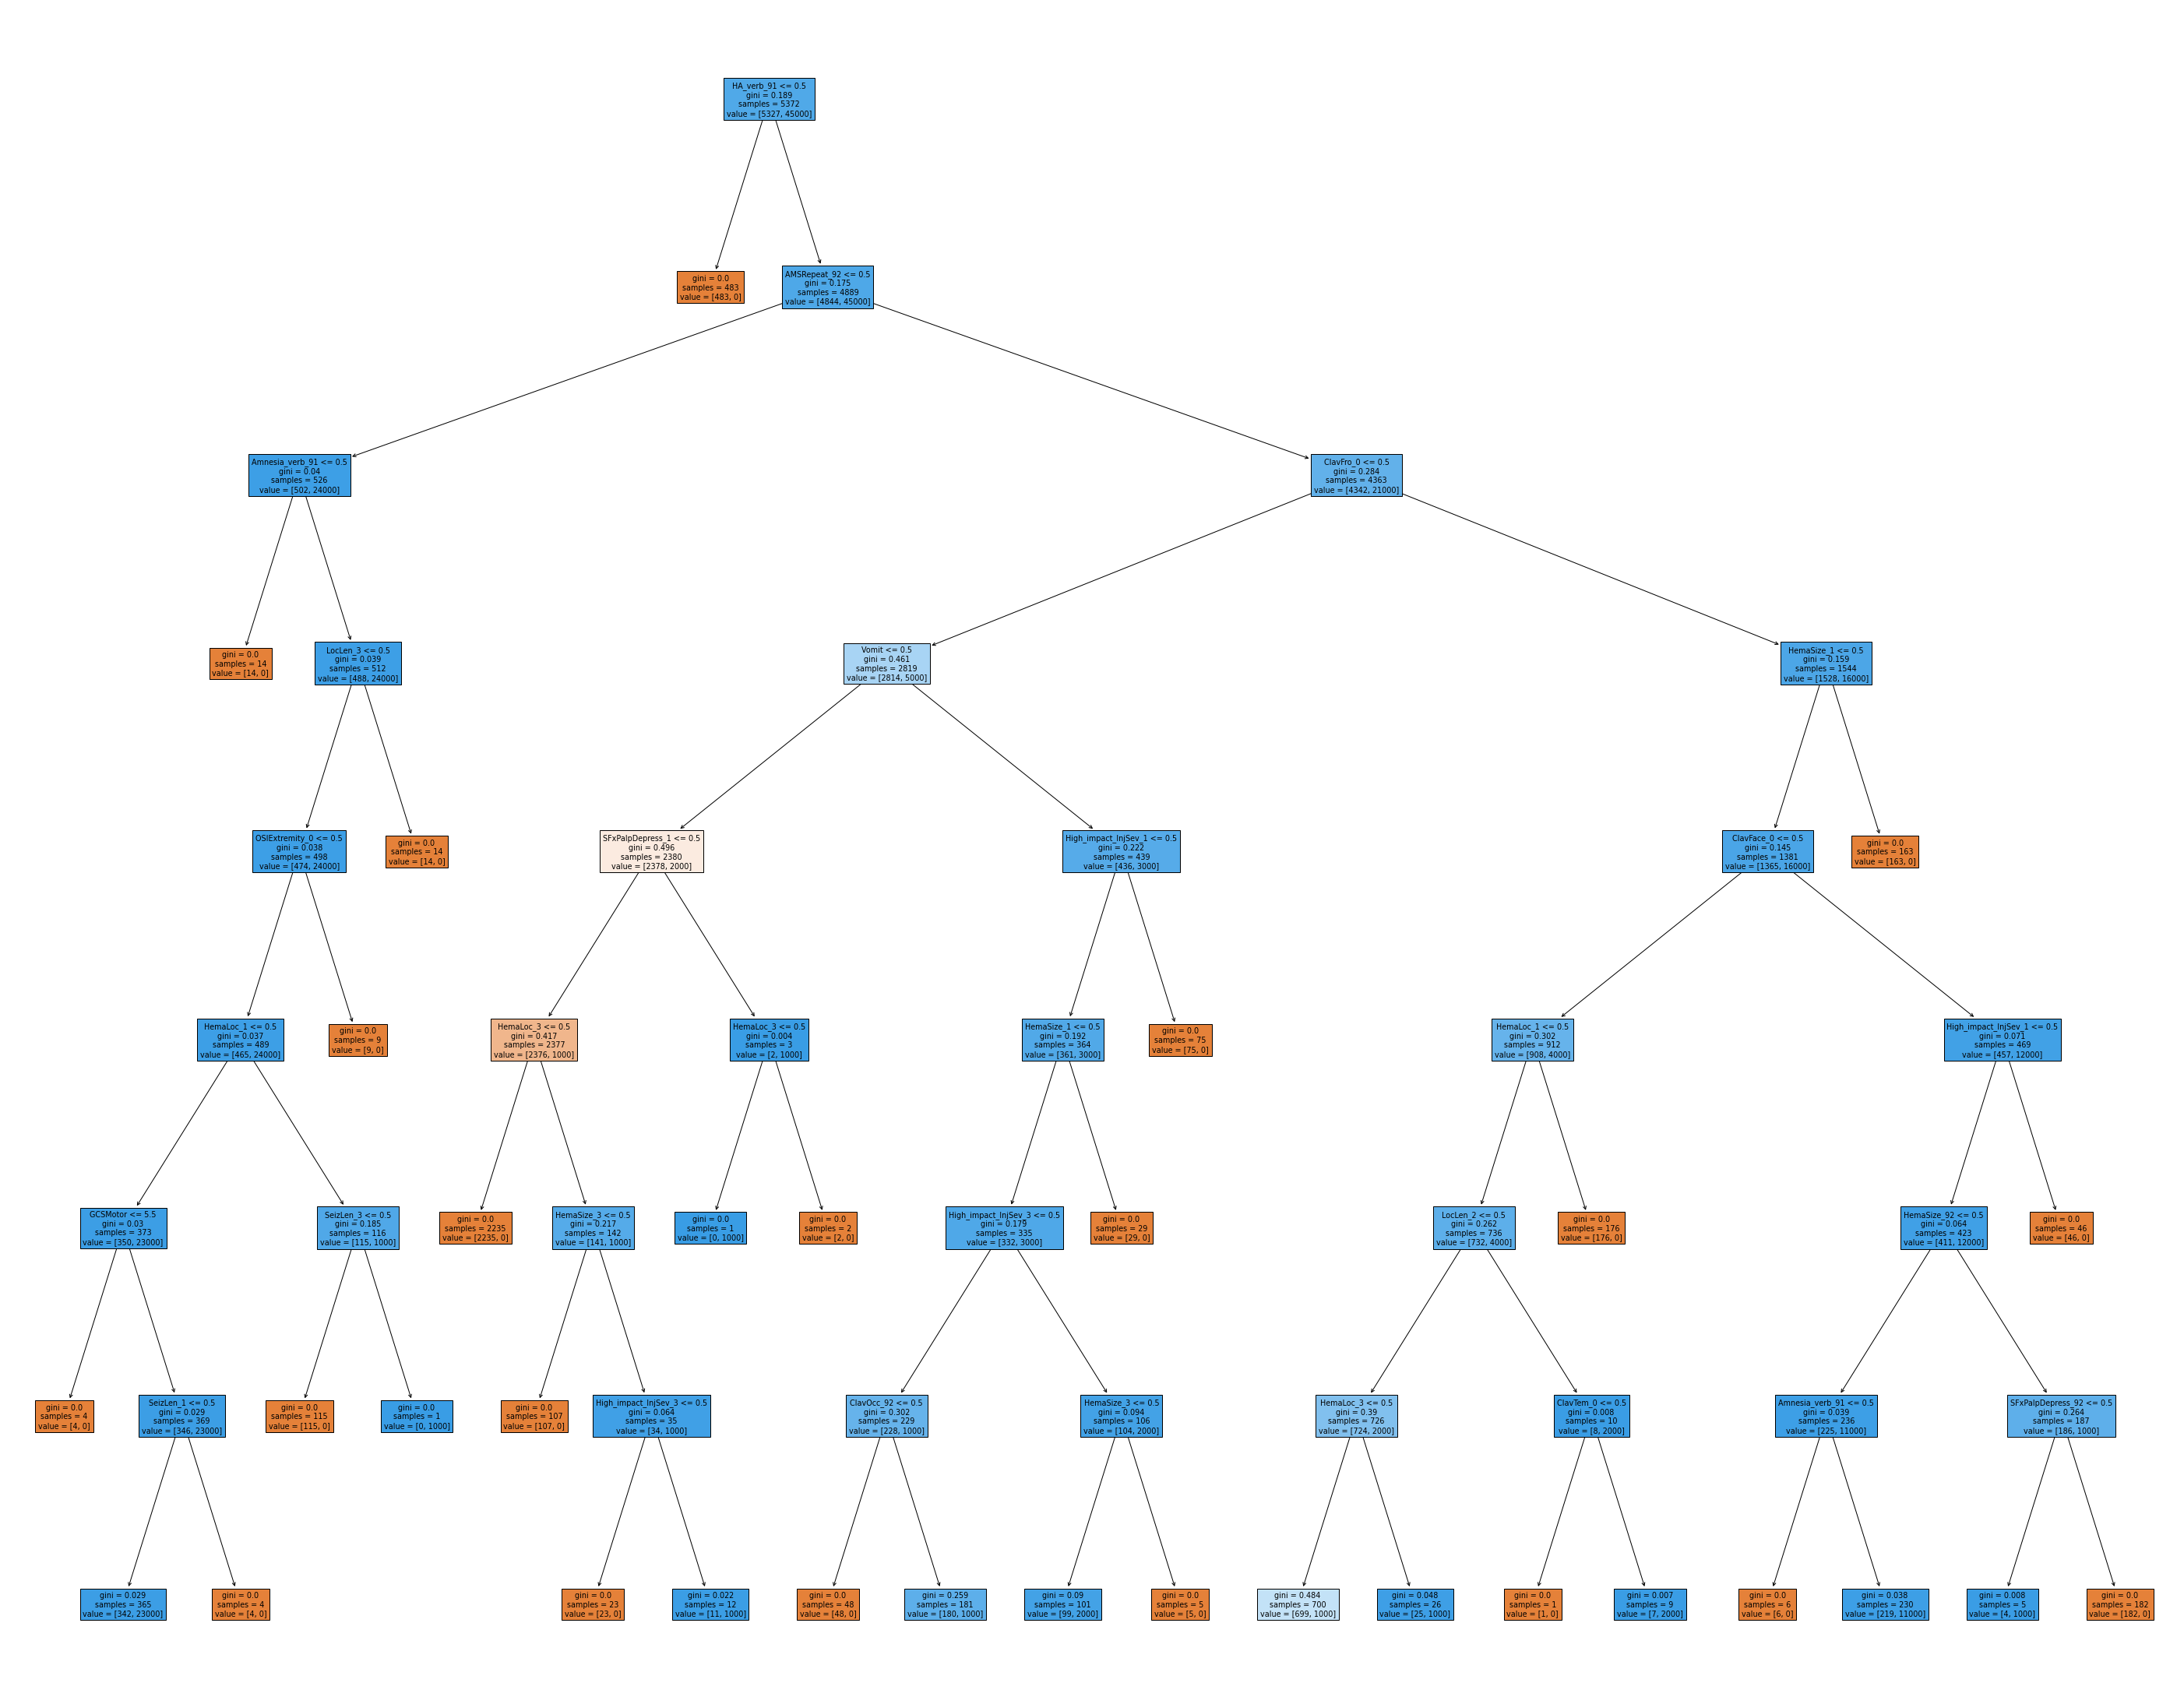

In [20]:
# fit decition tree
dt = DecisionTreeClassifier(max_depth=8, class_weight={0: 1, 1: 1e3})
dt.fit(X_train_young, y_train_young)
stats, threshes = predict_and_save(dt,'decision_tree', X_train_young, X_tune_young, y_train_young, y_tune_young)
# plt.xlim((0.8, 1.0))
# plt.ylim((0.5, 1.0))
plt.show()

fig = plt.figure(figsize=(50, 40))
plot_tree(dt, feature_names=feature_names, filled=True)
plt.show()